In [ ]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from pandas.tseries.offsets import BDay
import time
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas

In [ ]:
universe = master.baskets.get_index_historical_components('GSPC')
P = func.presence_matrix(universe).loc['2008':]
P.sum(1).plot()
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
income_statement = pd.read_parquet('data/US/income_statement.pq')
earnings = pd.read_parquet('data/US/earnings.pq')
cash_flow = pd.read_parquet('data/US/cash_flow.pq')

In [ ]:
earnings = pd.read_parquet('data/US/earnings.pq')
earnings['Date'] = pd.to_datetime(earnings['reportDate'])
earnings = earnings.droplevel(0).set_index('Date',append=True)
earnings = earnings.reorder_levels(['Date','Ticker'])
earnings = earnings[~earnings.index.duplicated(keep='first')]
earnings = earnings[earnings['epsActual'].notna()]

earnings

In [ ]:
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
balance_sheet['Date'] = pd.to_datetime(balance_sheet['filing_date'])
balance_sheet = balance_sheet.droplevel(0).set_index('Date',append=True)
balance_sheet = balance_sheet.reorder_levels(['Date','Ticker'])
balance_sheet = balance_sheet[~balance_sheet.index.duplicated(keep='first')]

balance_sheet

In [ ]:
cash_flow = pd.read_parquet('data/US/cash_flow.pq')
cash_flow['Date'] = pd.to_datetime(cash_flow['filing_date'])
cash_flow = cash_flow.droplevel(0).set_index('Date',append=True)
cash_flow = cash_flow.reorder_levels(['Date','Ticker'])
cash_flow = cash_flow[~cash_flow.index.duplicated(keep='first')]
cash_flow

In [ ]:
income_statement = pd.read_parquet('data/US/income_statement.pq')
income_statement['Date'] = pd.to_datetime(income_statement['filing_date'])
income_statement = income_statement.droplevel(0).set_index('Date',append=True)
income_statement = income_statement.reorder_levels(['Date','Ticker'])
income_statement = income_statement[~income_statement.index.duplicated(keep='first')]
income_statement

In [110]:
earnings['EarningsQuarter'] = pd.to_datetime(earnings['reportDate']).dt.to_period('Q')
earnings['IsReporting'] = 1

def DATES_EARNINGS(data:pd.DataFrame,start:float,end:float,_days_before:int,_days_after:int):

    all_earnings =data['EarningsQuarter'].dropna().unique().tolist()
    dates_earnings = pd.DataFrame(index = all_earnings,columns = ['start_pre','end_pre','start','end','start_post','end_post'])

    for earning in all_earnings:

        sample = data[data['EarningsQuarter']==earning][['IsReporting']]
        
        sample['IsReporting_%'] = sample['IsReporting'].div(sample['IsReporting'].sum())
        df = pd.DataFrame(sample.groupby(level=0)['IsReporting_%'].sum())
        tmp = (df['IsReporting_%']>start ) & (df['IsReporting_%']<end )

        try :
            dates_earnings.loc[earning,'start'] = df[tmp].index[0]
            dates_earnings.loc[earning,'end'] = df[tmp].index[-1]
            dates_earnings.loc[earning,'start_pre'] = dates_earnings.loc[earning,'start'] + BDay(-1- _days_before)
            dates_earnings.loc[earning,'end_pre'] = dates_earnings.loc[earning,'start'] + BDay(-1)
            dates_earnings.loc[earning,'start_post'] = dates_earnings.loc[earning,'end'] + BDay(1)
            dates_earnings.loc[earning,'end_post'] = dates_earnings.loc[earning,'end'] + BDay(1+_days_after)
            
        except :
            ''
    return dates_earnings.sort_index()

dates_earnings = DATES_EARNINGS(earnings,0.03,0.95,10,10).dropna()
dates_earnings

,start_pre,end_pre,start,end,start_post,end_post
1992Q2,1992-04-06 00:00:00,1992-04-20 00:00:00,1992-04-21 00:00:00,1992-06-30 00:00:00,1992-07-01 00:00:00,1992-07-15 00:00:00
1993Q1,1993-01-01 00:00:00,1993-01-15 00:00:00,1993-01-18 00:00:00,1993-03-31 00:00:00,1993-04-01 00:00:00,1993-04-15 00:00:00
1993Q2,1993-03-29 00:00:00,1993-04-12 00:00:00,1993-04-13 00:00:00,1993-06-30 00:00:00,1993-07-01 00:00:00,1993-07-15 00:00:00
1993Q3,1993-06-29 00:00:00,1993-07-13 00:00:00,1993-07-14 00:00:00,1993-09-30 00:00:00,1993-10-01 00:00:00,1993-10-15 00:00:00
1993Q4,1993-09-30 00:00:00,1993-10-14 00:00:00,1993-10-15 00:00:00,1993-12-31 00:00:00,1994-01-03 00:00:00,1994-01-17 00:00:00
...,...,...,...,...,...,...
2022Q3,2022-07-05 00:00:00,2022-07-19 00:00:00,2022-07-20 00:00:00,2022-08-04 00:00:00,2022-08-05 00:00:00,2022-08-19 00:00:00
2022Q4,2022-10-04 00:00:00,2022-10-18 00:00:00,2022-10-19 00:00:00,2022-11-08 00:00:00,2022-11-09 00:00:00,2022-11-23 00:00:00
2023Q1,2023-01-10 00:00:00,2023-01-24 00:00:00,2023-01-25 00:00:00,2023-02-28 00:00:00,2023-03-01 00:00:00,2023-03-15 00:00:00
2023Q2,2023-04-10 00:00:00,2023-04-24 00:00:00,2023-04-25 00:00:00,2023-05-31 00:00:00,2023-06-01 00:00:00,2023-06-15 00:00:00


In [111]:
def business_days(start_date,end_date):
    dates_list = pd.date_range(start=start_date,end=end_date,freq ='D')
    business_days_list = [date for date in dates_list if date.weekday()<5]
    return business_days_list

dates_earnings['dates_pre'] =   dates_earnings.apply(lambda x: business_days(x['start_pre'],x['end_pre']),axis=1)
dates_earnings['dates_earn'] =   dates_earnings.apply(lambda x: business_days(x['start'],x['end']),axis=1)
dates_earnings['dates_post'] =   dates_earnings.apply(lambda x: business_days(x['start_post'],x['end_post']),axis=1)
dates_earnings['dates_earn_cumul'] = dates_earnings['dates_earn'].cumsum()



In [112]:
eps_actual = earnings['epsActual'].unstack().reindex_like(P).ffill().astype(float)
eps_estimate = earnings['epsEstimate'].unstack().reindex_like(P).ffill().astype(float)
eps = (eps_actual - eps_estimate).reindex_like(P).ffill()[P]

In [113]:
total_revenue = income_statement['totalRevenue'].unstack().reindex_like(P).ffill().astype(float)
cost_revenue = income_statement['costOfRevenue'].unstack().reindex_like(P).ffill().astype(float)
gross_margin = ((total_revenue - cost_revenue)/ total_revenue).stack()
gross_margin = gross_margin.unstack().reindex_like(P).ffill()[P]
gross_margin

Ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABI,ABK,ABMD,...,XRX,XTO,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
2008-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31,0.551253,0.02516,0.246815,NaN,0.429623,0.724225,0.034146,NaN,NaN,NaN,...,NaN,NaN,0.380478,NaN,0.468053,0.71492,0.455755,NaN,NaN,0.679902
2023-04-03,0.551253,0.02516,0.246815,NaN,0.429623,0.724225,0.034146,NaN,NaN,NaN,...,NaN,NaN,0.380478,NaN,0.468053,0.71492,0.455755,NaN,NaN,0.679902
2023-04-04,0.551253,NaN,0.246815,NaN,0.429623,0.724225,0.034146,NaN,NaN,NaN,...,NaN,NaN,0.380478,NaN,0.468053,0.71492,0.455755,NaN,NaN,0.679902
2023-04-05,0.551253,NaN,0.246815,0.440632,0.429623,0.724225,0.034146,NaN,NaN,NaN,...,NaN,NaN,0.380478,NaN,0.468053,0.71492,0.455755,NaN,NaN,0.679902


In [114]:
mkt_cap = market_data['MktCap'].unstack().reindex_like(P).astype(float)
ltdebt = balance_sheet['longTermDebt'].unstack().reindex_like(P).ffill().astype(float)
stdebt = balance_sheet['shortTermDebt'].unstack().reindex_like(P).ffill().astype(float)
cash_equiv = balance_sheet['cashAndEquivalents'].unstack().reindex_like(P).ffill().astype(float)
EV = mkt_cap + (ltdebt+stdebt)  - cash_equiv.fillna(0)
ebitda = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)
EM = EV / ebitda

In [ ]:
simulations_earnings = dates_earnings.loc['2017Q1':].index
signal = pd.DataFrame().reindex_like(P)

In [123]:
simulations_earnings = dates_earnings.loc['2020Q1':].index
signal = pd.DataFrame().reindex_like(P)
for i,earning in enumerate(tqdm(simulations_earnings[1:-1])):
    i = i+1
    quarter = simulations_earnings[i]
    prev_quarter = simulations_earnings[i-1]
    # print(prev_quarter,'prev quarter')
    start_train = market_data.head(1).index[0]
    dates_train = dates_earnings.loc[prev_quarter,'dates_earn_cumul']
    end_train = dates_earnings.loc[prev_quarter,'end']

    assert end_train == dates_train[-1]
    
    dates_signal = dates_earnings.loc[quarter,'dates_earn']
    tickers = R[R.index.isin(dates_signal)].dropna(1,'all').columns.tolist()
    for ticker in  tickers:
        try :
            returns = R[P].sub(R[P].mean(1),0)[ticker]
            em_ticker, eps_ticker,gm_ticker = EM[ticker],eps[ticker],gross_margin[ticker]
            df = pd.DataFrame({'em':em_ticker,
                               'eps':eps_ticker,
                               'gm':gm_ticker,
                               'ret':returns})
        
            df_train = df[df.index.isin(dates_train)].dropna()
            # print(df_train.sort_index().index[-1],'last train sample')
            df_train = df_train.rank(axis=0,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
            df_test  = df[df.index.isin(dates_signal)].dropna()
            df_test = df_test.rank(axis=0,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
            
            assert df_test.index[0] > df_train.index[-1]
            input_dates = df_test.index
            xdata = df_train[['em','eps','gm']].values
            ydata = df_train['ret'].values
            neigh = KNeighborsRegressor(n_neighbors=6).fit(xdata,ydata)
            # print(neigh.get_params(deep=True))
            pred = neigh.predict(df_test[['em','eps','gm']].values)

            assert len(input_dates) == len(pred.ravel())

            signal.loc[input_dates,ticker] = pred.ravel()
            # print(pred.ravel())
        
        except :
            ''
            # print(ticker,quarter)


    


 69%|██████▉   | 9/13 [15:07<06:47, 101.75s/it]

Sharpe      6.5
Turnover    0.0
biais       4.8
dtype: float64

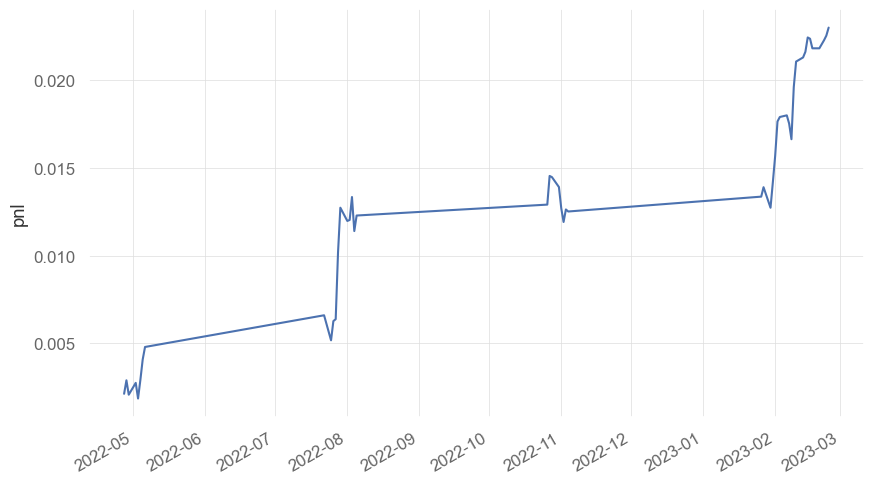

In [121]:
SIGNAL = signal.reindex_like(P)[P]

SIGNAL = SIGNAL[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
# SIGNAL[SIGNAL.abs()<0.5] = None
SIGNAL = SIGNAL[P].groupby(GICS['gicsect'],axis=1).apply(center)
SIGNAL = SIGNAL[P].div(SIGNAL.abs().sum(1),0)

pnl = (SIGNAL[P].shift()*R).dropna(0,'all').sum(1)
sr = sharpe(pnl)
turnover = SIGNAL.fillna(0).diff().abs().sum(1).mean()
pnl.cumsum().plot()
plt.ylabel('pnl')
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':pnl.mean()*1e4}).round(1)